In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
import re

from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def list_to_string(liste):
    sentence_string = ""
    for elem in liste:
        sentence_string += elem
        sentence_string += ". "
    return sentence_string

filename = "data/AFD_Wahlprogramm_2021.txt"

def init_data(filename):
    with open(filename, encoding="utf8") as f:
        text = f.read()
        #text = text.replace(r'\\d+\\n', '$')
        #text=   re.sub("\n\n", ".", text)
        #text=   re.sub("\d+.", ".", text)
        text=   re.sub(" \d+\n", ".", text)
        text=   re.sub("\n\d+", " ", text)
        text=   re.sub("\n", " ", text)
    sentences = re.split(r' *[\.\?!][\'"\)\]]* *', text)
    text = list_to_string(sentences)
    return text


In [7]:
def change_text(text, additionals=[]):
    text = re.sub(" \d+\n", ".", text)
    text = re.sub("\n\d+", " ", text)
    text = re.sub("\n", " ", text)
    text = re.sub("- ", "", text)
    text = re.sub("[0-9]", "", text)
    text = re.sub("()", "", text)
    for entry in additionals:
        text = re.sub(entry, "", text)
    sentences = re.split(r' *[\.\?!][\'"\)\]]* *', text)
    return sentences

In [8]:
text_afd = init_data("data/AFD_Wahlprogramm_2021.txt")
text_cdu = init_data("data/CDU-CSU_Wahlrprogramm_2021.txt")
text_gruene = init_data("data/DIE_GRUENEN_Wahlprogramm_2021.txt")
text_linke = init_data("data/DIE_LINKE_Wahlprogramm_2021.txt")
text_spd = init_data("data/SPD_Wahlprogramm_2021.txt")
text_fdp = init_data("data/FDP_Wahlprogramm_2021.txt")

In [9]:
data = pd.DataFrame(data={"text": [text_afd, text_cdu, text_spd, text_fdp, text_gruene, text_linke], "partei": ["AFD", "CDU", "SPD", "FDP", "GRÜNE", "LINKE"]})
data

,text,partei
0,Deutschland. Aber normal. normal. Programm der...,AFD
1,Inhaltsverzeichnis Einleitung. . . . . . . . ...,CDU
2,"> | >"" EZDRESPEKT VOR DEINER AU] (0) |. > * ...",SPD
3,Freie Demokraten Freie Demokraten Beschluss d...,FDP
4,IEITTESALTENTR Alles ist drin. Bundestagswahlp...,GRÜNE
5,"Zeitzu handeln. Für soziale Sicherheit, Friede...",LINKE


In [10]:
def sentence_tokenization(data, col):
    # Lists to store the results during the calculations
    sentences = []
    lengths_of_sentences = []

    # Initialize names for columns
    col_name = col + "_sent_tok"
    col_name_length = col + "_num_of_sent"

    # Iterating through the data row for row splitting the text in sentences and counting them
    for entry in tqdm(data[col]):
        col_sentences = nltk.sent_tokenize(entry)
        sentences.append(col_sentences)
        lengths_of_sentences.append(len(col_sentences))
    
    # Insert results to dataframe
    data[col_name] = sentences
    data[col_name_length] = lengths_of_sentences

    return data

In [11]:
def word_tokenization(data, col):
    # Lists to store the results during the calculations
    words = []
    length_of_words = []

    # Initialize names for columns
    col_name = col + "_word_tok"
    col_name_length = col + "_num_of_word"

    # Iterating through the data row for row splitting the text in words and counting them
    for i in tqdm(range(len(data))):
        word_list = nltk.regexp_tokenize(data[col][i], pattern='\w+')
        words.append(word_list)
        length_of_words.append(len(word_list))

    # Insert results to dataframe
    data[col_name] = words
    data[col_name_length] = length_of_words

    return data

In [12]:
def stemming_lemming(data, col):
    # Initialize Stemmer and Lemmatizer
    pst = nltk.PorterStemmer()
    wlem = nltk.WordNetLemmatizer()

    # Lists to store results
    stems = []
    lemms = []

    # Initialize names for columns
    col_name_stems = col + "_stems"
    col_name_lemms = col + "_lemms"

    # Iterating through the data row for row creating stems and lemms
    for i in tqdm(range(len(data))):
        stem_cache = []
        lemm_cache = []

        for c in data[col][i]:
            stem_cache.append(pst.stem(c))
            lemm_cache.append(wlem.lemmatize(c))
        
        stems.append(stem_cache)
        lemms.append(lemm_cache)

    # Insert results to dataframe
    data[col_name_stems] = stems
    data[col_name_lemms] = lemms
        
    return data

In [13]:
def stopwords_count_and_removal(data, col, language="german"):

    stoplist = stopwords.words(language)

    number_of_stopwords = []
    text_without_stopwords = []

    col_name_number_of_stopwords = col + "_num_of_stopwords"
    col_name_without_stopwords = col + "_without_stopwords"

    for i in tqdm(range(len(data))):
        no_of_words = 0
        without_stopwords = []
        for word in data[col][i]:
            if word in stoplist:
                no_of_words += 1
            else:
                without_stopwords.append(word)
        
        text_without_stopwords.append(without_stopwords)
        number_of_stopwords.append(no_of_words)

    data[col_name_number_of_stopwords] = number_of_stopwords
    data[col_name_without_stopwords] = text_without_stopwords


    return data

In [14]:
def create_word_dict(data, without_stopwords=True, with_stopwords=False):

    if without_stopwords:
        word_dict_without_stopwords = {}
        
    if with_stopwords:
        word_dict_with_stopwords = {}

    stopword_list = stopwords.words('german')
    for i in tqdm(range(len(data))):
        if without_stopwords:
            for word in literal_eval(data["text_word_tok"][i]):
                if word not in [",", ".", ")", "(", "{", "}", "[", "]", ":", ";", "\"\"", "...", "I", "-PRON-", "-", "'", "'s", "urllink"] and word not in stopword_list:
                    if word in word_dict_without_stopwords.keys():
                        word_dict_without_stopwords[word] += 1
                    else:
                        word_dict_without_stopwords[word] = 1

        if with_stopwords:
            for word in literal_eval(data["text_word_tok"][i]):
                if word not in [",", ".", ")", "(", "{", "}", "[", "]", ":", ";", "\"\"", "...", "I", "-PRON-", "-", "'"]:
                    if word in word_dict_with_stopwords.keys():
                        word_dict_with_stopwords[word] += 1
                    else:
                        word_dict_with_stopwords[word] = 1

    if without_stopwords and with_stopwords:
        return word_dict_without_stopwords, word_dict_with_stopwords
    elif without_stopwords:
        return word_dict_without_stopwords
    elif with_stopwords:
        return word_dict_with_stopwords
    else:
        print("Nothing to return selected")
        return 0

In [15]:
def visualize_specific_words(dictionary, limit=10, save_fig=True, save_name="standard_save_name"):
    data_as_df = pd.DataFrame(data={"word": dictionary.keys(), "number": dictionary.values()})
    sorted_df = data_as_df.sort_values(by="number", ascending=False)

    figure = sb.barplot(data=sorted_df[:limit], x="word", y="number", palette="deep")
    figure.set_xlabel("Wörter")
    figure.set_ylabel("Häufigkeit")

    if save_fig:
        fig = figure.get_figure()
        fig.savefig("images/words/" + str(save_name + ".jpg"))

    return fig.get_figure()

In [16]:
def getNumbers(data):
    data["num_nouns"] = 0
    data["num_verbs"] = 0
    data["num_conjs"] = 0
    num_nouns, num_verbs, num_conjs = [], [], []

    for i in tqdm(range(len(data))):
        nouns, verbs, conjs = 0, 0, 0
        for elem in literal_eval(data["pos_list"][i]):
            #print(elem)
            if elem == "NOUN":
                nouns += 1
            elif elem == "VERB":
                verbs += 1
            elif elem == "CCONJ":
                conjs += 1
        num_nouns.append(nouns)
        num_verbs.append(verbs)
        num_conjs.append(conjs)

    data["num_nouns"] = num_nouns
    data["num_verbs"] = num_verbs
    data["num_conjs"] = num_conjs

    return data

def getRatios(data):
    data["ratio_nouns"] = data.apply(lambda row: (row["num_nouns"] / row["word_count"]), axis=1)
    data["ratio_verbs"] = data.apply(lambda row: (row["num_verbs"] / row["word_count"]), axis=1)
    data["ratio_conjs"] = data.apply(lambda row: (row["num_conjs"] / row["word_count"]), axis=1)

    return data

In [17]:
data = sentence_tokenization(data, "text")
data = word_tokenization(data, "text")
data = stopwords_count_and_removal(data, "text")
data

100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


,text,partei,text_sent_tok,text_num_of_sent,text_word_tok,text_num_of_word,text_num_of_stopwords,text_without_stopwords
0,Deutschland. Aber normal. normal. Programm der...,AFD,"[Deutschland., Aber normal., normal., Programm...",1888,"[Deutschland, Aber, normal, normal, Programm, ...",28600,0,"[D, e, u, t, s, c, h, l, a, n, d, ., , A, b, ..."
1,Inhaltsverzeichnis Einleitung. . . . . . . . ...,CDU,[Inhaltsverzeichnis Einleitung. . . . . . . ....,2963,"[Inhaltsverzeichnis, Einleitung, 2s0000000000s...",46662,0,"[I, n, h, a, l, t, s, v, e, r, z, e, i, c, h, ..."
2,"> | >"" EZDRESPEKT VOR DEINER AU] (0) |. > * ...",SPD,"[> | >"" EZDRESPEKT VOR DEINER AU] (0) |., > *...",1780,"[EZDRESPEKT, VOR, DEINER, AU, 0, DAS, ZUKUNFTS...",25552,0,"[>, , |, , >, "", , E, Z, D, R, E, S, P, E, ..."
3,Freie Demokraten Freie Demokraten Beschluss d...,FDP,[Freie Demokraten Freie Demokraten Beschluss ...,2361,"[Freie, Demokraten, Freie, Demokraten, Beschlu...",39575,0,"[F, r, e, i, e, , D, e, m, o, k, r, a, t, e, ..."
4,IEITTESALTENTR Alles ist drin. Bundestagswahlp...,GRÜNE,"[IEITTESALTENTR Alles ist drin., Bundestagswah...",5004,"[IEITTESALTENTR, Alles, ist, drin, Bundestagsw...",75885,0,"[I, E, I, T, T, E, S, A, L, T, E, N, T, R, , ..."
5,"Zeitzu handeln. Für soziale Sicherheit, Friede...",LINKE,"[Zeitzu handeln., Für soziale Sicherheit, Frie...",5202,"[Zeitzu, handeln, Für, soziale, Sicherheit, Fr...",75507,0,"[Z, e, i, t, z, u, , h, a, n, d, e, l, n, ., ..."


In [18]:
data_afd = data[data["partei"] == "AFD"].reset_index()
data_cdu = data[data["partei"] == "CDU"].reset_index()
data_spd = data[data["partei"] == "SPD"].reset_index()
data_linke = data[data["partei"] == "LINKE"].reset_index()
data_fdp = data[data["partei"] == "FDP"].reset_index()
data_gruene = data[data["partei"] == "GRÜNE"].reset_index()

words_afd = []
words_cdu = []
words_spd = []
words_linke = []
words_fdp = []
words_gruene = []

for word in data_afd["text_word_tok"][0]:
    words_afd.append(word.lower())

for word in data_cdu["text_word_tok"][0]:
    words_cdu.append(word.lower())

for word in data_spd["text_word_tok"][0]:
    words_spd.append(word.lower())

for word in data_linke["text_word_tok"][0]:
    words_linke.append(word.lower())

for word in data_fdp["text_word_tok"][0]:
    words_fdp.append(word.lower())

for word in data_gruene["text_word_tok"][0]:
    words_gruene.append(word.lower())

In [19]:
word_dict_afd = {}
word_dict_cdu = {}
word_dict_spd = {}
word_dict_fdp = {}
word_dict_linke = {}
word_dict_gruene = {}

stopword_list = stopwords.words("german")
own_filter = [",", ".", ")", "(", "{", "}", "[", "]", ":", ";", "\"\"", "...", "I", "-PRON-", "-", "'", "'s", "urllink", "ab", "e","kapitel", "90", "bündnis", "innen", "bundestagswahlprogramm"]

for word in words_afd:
    if word not in own_filter and word not in stopword_list:
        if word in word_dict_afd.keys():
            word_dict_afd[word] += 1
        else:
            word_dict_afd[word] = 1

for word in words_cdu:
    if word not in own_filter and word not in stopword_list:
        if word in word_dict_cdu.keys():
            word_dict_cdu[word] += 1
        else:
            word_dict_cdu[word] = 1

for word in words_spd:
    if word not in own_filter and word not in stopword_list:
        if word in word_dict_spd.keys():
            word_dict_spd[word] += 1
        else:
            word_dict_spd[word] = 1

for word in words_linke:
    if word not in own_filter and word not in stopword_list:
        if word in word_dict_linke.keys():
            word_dict_linke[word] += 1
        else:
            word_dict_linke[word] = 1

for word in words_fdp:
    if word not in own_filter and word not in stopword_list:
        if word in word_dict_fdp.keys():
            word_dict_fdp[word] += 1
        else:
            word_dict_fdp[word] = 1

for word in words_gruene:
    if word not in own_filter and word not in stopword_list:
        if word in word_dict_gruene.keys():
            word_dict_gruene[word] += 1
        else:
            word_dict_gruene[word] = 1


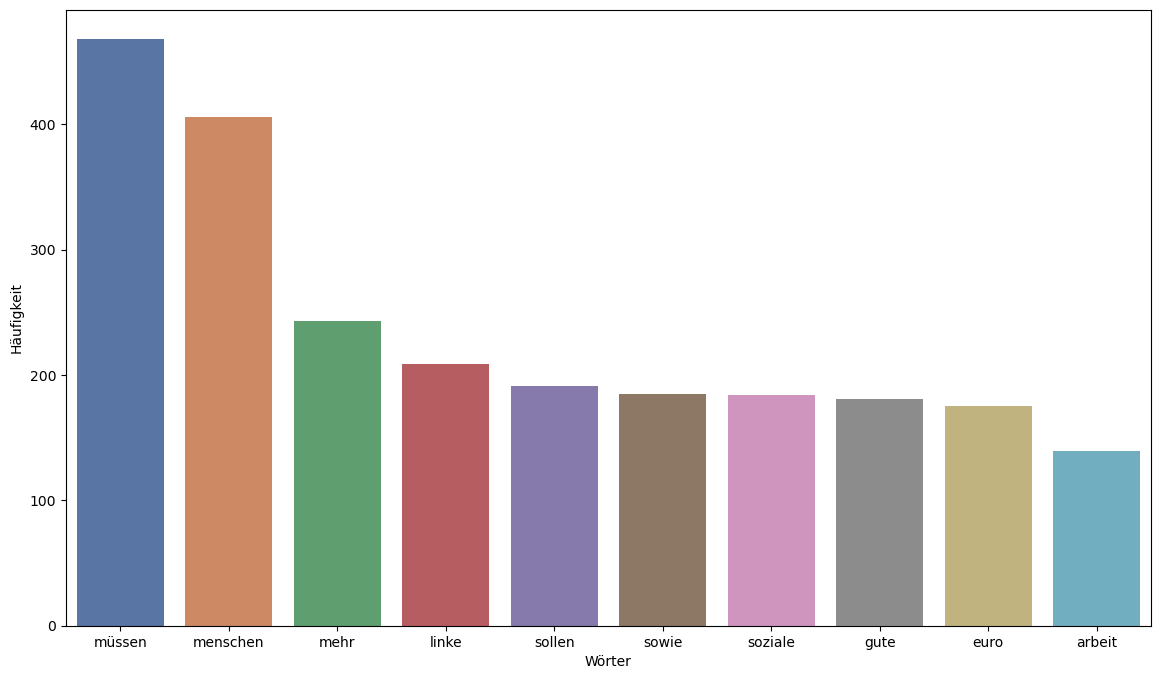

In [20]:
from matplotlib.pyplot import figure

figure(figsize=(14, 8))

fig_afd = visualize_specific_words(word_dict_afd, save_name="afd_most_words")
fig_cdu = visualize_specific_words(word_dict_cdu, save_name="cdu_most_words")
fig_spd = visualize_specific_words(word_dict_spd, save_name="spd_most_words")
fig_fdp = visualize_specific_words(word_dict_fdp, save_name="fdp_most_words")
fig_gruene = visualize_specific_words(word_dict_gruene, save_name="gruene_most_words")
fig_linke = visualize_specific_words(word_dict_linke, save_name="linke_most_words")